## Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
df = pd.read_csv('DHT Historical Data.csv')
df.head(10)

,Date,Price,Open,High,Low,Vol.,Change %
0,04/17/2024,"26,700.0","26,600.0","27,200.0","26,500.0",104.91K,1.14%
1,04/16/2024,"26,400.0","26,300.0","26,800.0","26,100.0",69.69K,-1.49%
2,04/15/2024,"26,800.0","26,900.0","27,400.0","26,500.0",51.17K,-0.37%
3,04/12/2024,"26,900.0","26,800.0","27,200.0","26,500.0",29.56K,1.51%
4,04/11/2024,"26,500.0","26,500.0","27,000.0","26,100.0",56.40K,-0.38%
5,04/10/2024,"26,600.0","26,800.0","26,900.0","26,500.0",27.07K,-0.37%
6,04/09/2024,"26,700.0","26,300.0","27,200.0","26,300.0",45.80K,-0.74%
7,04/08/2024,"26,900.0","26,800.0","27,100.0","26,500.0",23.60K,0.37%
8,04/05/2024,"26,800.0","27,200.0","27,300.0","24,600.0",173.17K,-1.83%
9,04/04/2024,"27,300.0","27,300.0","27,700.0","26,800.0",155.52K,-0.36%


## Data preprocessing

In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort the data by date in ascending order
df = df.sort_values('Date')

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)
df = df.replace(',', '', regex=True)

In [4]:
# Show Dataframe
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-01-03,11842.2,11224.9,11982.5,11224.9,40.97K,-0.24%
2019-01-04,11393.2,12207.0,12207.0,11393.2,0.92K,-3.79%
2019-01-07,11421.3,11786.1,11786.1,11252.9,44.97K,0.25%
2019-01-08,11421.3,11645.8,11645.8,11224.9,10.47K,0.00%
2019-01-09,11421.3,11758.0,11758.0,11224.9,8.62K,0.00%
...,...,...,...,...,...,...
2024-04-11,26500.0,26500.0,27000.0,26100.0,56.40K,-0.38%
2024-04-12,26900.0,26800.0,27200.0,26500.0,29.56K,1.51%
2024-04-15,26800.0,26900.0,27400.0,26500.0,51.17K,-0.37%


## Scale Data

In [5]:
# Select 'Close' column
data = df['Price'].values

In [6]:
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

## Split the data into train, validation and test set with a ratio of 7 : 1 : 2

In [7]:
# Define the size of train, validation, test set
train_size = int(len(data_scaled) * 0.8)
val_size = int(len(data_scaled) * 0.1)
test_size = len(data_scaled) - train_size - val_size

# Split the data into train, test, and validation sets
train_data = data_scaled[:train_size]
val_data = data_scaled[train_size:train_size + val_size]
test_data = data_scaled[train_size + val_size:]

## Create and add data into X, y

In [8]:
# Function to prepare data for LSTM
def add_data(data, sequence_length=60):
    X, Y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), 0])
        Y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(Y)

In [9]:
# Prepare sequences
sequence_length = 60
train_last_windowsize = train_data[-sequence_length:]
val_last_windowsize = val_data[-sequence_length:]

val_data_extended = np.concatenate((train_last_windowsize, val_data), axis=0)
test_data_extended = np.concatenate((val_last_windowsize, test_data), axis=0)

X_train, y_train = add_data(train_data, sequence_length)
X_val, y_val = add_data(val_data_extended, sequence_length)
X_test, y_test = add_data(test_data_extended, sequence_length)

In [10]:
# Reshape data for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## Build Model

In [11]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

## Training Model

In [12]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=2)

Epoch 1/50
32/32 - 13s - loss: 0.0106 - val_loss: 0.0349 - 13s/epoch - 412ms/step
Epoch 2/50
32/32 - 4s - loss: 0.0027 - val_loss: 0.0248 - 4s/epoch - 128ms/step
Epoch 3/50
32/32 - 3s - loss: 0.0023 - val_loss: 0.0239 - 3s/epoch - 95ms/step
Epoch 4/50
32/32 - 3s - loss: 0.0024 - val_loss: 0.0275 - 3s/epoch - 96ms/step
Epoch 5/50
32/32 - 4s - loss: 0.0019 - val_loss: 0.0232 - 4s/epoch - 115ms/step
Epoch 6/50
32/32 - 4s - loss: 0.0019 - val_loss: 0.0273 - 4s/epoch - 121ms/step
Epoch 7/50
32/32 - 3s - loss: 0.0023 - val_loss: 0.0162 - 3s/epoch - 96ms/step
Epoch 8/50
32/32 - 3s - loss: 0.0022 - val_loss: 0.0151 - 3s/epoch - 95ms/step
Epoch 9/50
32/32 - 4s - loss: 0.0018 - val_loss: 0.0170 - 4s/epoch - 124ms/step
Epoch 10/50
32/32 - 4s - loss: 0.0016 - val_loss: 0.0152 - 4s/epoch - 114ms/step
Epoch 11/50
32/32 - 3s - loss: 0.0015 - val_loss: 0.0202 - 3s/epoch - 96ms/step
Epoch 12/50
32/32 - 3s - loss: 0.0017 - val_loss: 0.0154 - 3s/epoch - 96ms/step
Epoch 13/50
32/32 - 4s - loss: 0.0014 - v

## Predict Close price in test and validation set

In [13]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

5/5 [==============================] - 0s 25ms/step


## Transform data back to the original

In [15]:
# Inverse transform the predictions and actual values
y_pred = scaler.inverse_transform(y_pred)
y_val = scaler.inverse_transform(y_val.reshape(-1, 1))
y_pred_val = scaler.inverse_transform(y_pred_val)
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)
val_data = scaler.inverse_transform(val_data)

## Calculate the error of the model

In [16]:
# Calculate error metrics
test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_test, y_pred)

print(f"MAPE on Test set: {test_mape}")
print(f"RMSE on Test set: {test_rmse}")
print(f"MSLE on Test set: {test_msle}")

MAPE on Test set: 625634339.3555728
RMSE on Test set: 462363484.67052513
MSLE on Test set: 376.02851930924226


In [17]:
# The error in validation set
val_mape = mean_absolute_percentage_error(y_val, y_pred_val)
val_mse = mean_squared_error(y_val, y_pred_val)
val_rmse = np.sqrt(val_mse)
val_msle = mean_squared_log_error(y_val, y_pred_val)

print(f"MAPE on Validate set: {val_mape}")
print(f"RMSE on Validate set: {val_rmse}")
print(f"MSLE on Validate set: {val_msle}")

MAPE on Validate set: 0.056867782893605744
RMSE on Validate set: 37936046.94524101
MSLE on Validate set: 0.00662768314643713


## Predict Close price for 30 next days

In [18]:
last_sequence_days = data_scaled[-sequence_length:].reshape(1, -1, 1)
y_next_30_days = []

for i in range(30):
    next_day_pred = model.predict(last_sequence_days)
    y_next_30_days.append(next_day_pred[0][0])
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)


1/1 [==============================] - 0s 29ms/step


In [19]:
# Show the result of predict 30 next days
y_next_30_days = scaler.inverse_transform(np.array(y_next_30_days).reshape(-1, 1))
print(y_next_30_days.flatten())

[25233.361 25168.412 25063.213 24921.287 24753.613 24572.303 24387.191
 24204.854 24028.846 23860.576 23700.146 23547.014 23400.45  23259.713
 23124.2   22993.424 22867.002 22744.627 22626.045 22511.027 22399.38
 22290.92  22185.479 22082.91  21983.08  21885.865 21791.15  21698.832
 21608.822 21521.033]


## Model visualization

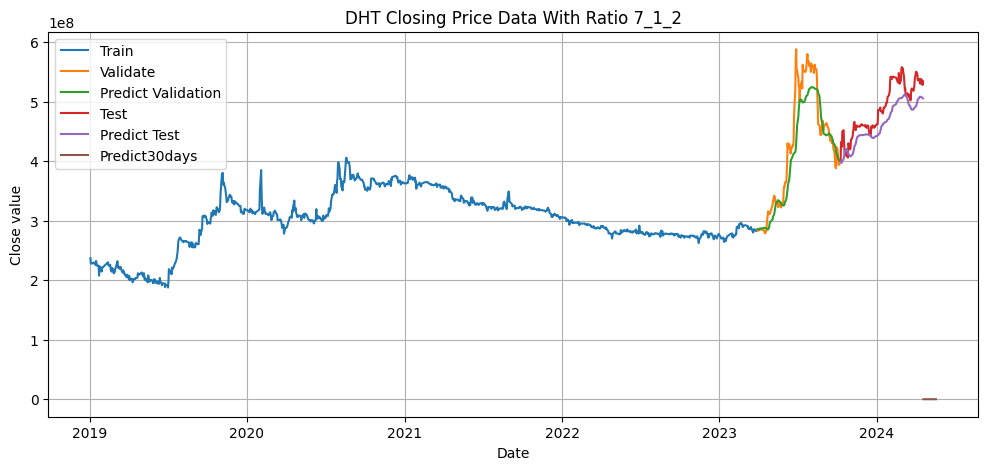

In [20]:
# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(df[:train_size].index, train_data)
plt.plot(df[train_size:train_size + val_size].index, val_data)
plt.plot(df[train_size:train_size + val_size].index, y_pred_val)
plt.plot(df[train_size + val_size:].index, test_data)
plt.plot(df[train_size + val_size:].index, y_pred)
plt.plot(pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=30), y_next_30_days)
plt.legend(['Train', 'Validate', 'Predict Validation', 'Test', 'Predict Test', 'Predict30days'])
plt.grid()
plt.title("DHT Closing Price Data With Ratio 7_1_2")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('RNN_712_DHT.png')
plt.show()